Case: Bike Sharing Data

Context: 
Bike-sharing systems are a new generation of traditional bike rentals where the whole process, from membership, rental, and return back, has become automatic. Through these systems, a user can easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousand bicycles. Today, great interest exists in these systems due to their important role in traffic, environmental, and health issues. Apart from interesting real-world applications of bike-sharing systems, the characteristics of data generated by these systems make them attractive for research. Unlike other transport services such as buses or subways, the duration of travel, departure, and arrival position is explicitly recorded in these systems. This feature turns the bike-sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that the most important events in the city could be detected by monitoring these data.

Data:

- dteday: date season: season (1: winter, 2: spring, 3: summer, 4: fall)

- hr: hour (0 to 23) 

- holiday: holiday or not

- temp: normalized temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-8, t_max=+39 (only in hourly scale)

- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-16, t_max=+50 (only in hourly scale)

- hum: normalized humidity. The values are divided into 100 (max)     

- casual: count of casual users

- registered: count of registered users

- cnt: count of total rental bikes including both casual and registered

- weathersit: 

    1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

Case Study Objective: Usage Prediction Models

High-level solution: Develop machine learning models to predict the number of bikes needed at different stations at various times based on historical data, weather conditions, and holidays.

Method and Steps:
1. Data Collection and Preparation
2. Exploratory Data Analysis (EDA)
3. Feature selection
4. Model Selection and Training
5. Model Evaluation
6. Model Deployment

Step 1: Data Collection and Preparation

In [1]:
#Import library

import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import scipy #for statistical analysis
from sklearn.model_selection import train_test_split


# Deep Learning
import tensorflow as tf
from tensorflow import compat

In [2]:
# Read the CSV file
file_path = 'C:\\capstoneproject3\\data_bike_sharing.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())

# Check the type of the DataFrame
df.info()

# Check for missing values
missing_values = df.isna().sum()
print("Missing Values:")
print(missing_values)

# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f'Number of duplicate rows: {duplicate_rows.shape[0]}')

# Check for values outside expected ranges
# Example: Checking for negative values in count columns
invalid_counts = df[(df['casual'] < 0) | (df['registered'] < 0) | (df['cnt'] < 0)]
print("Rows with Invalid Counts:")
print(invalid_counts)

# Check for invalid values in categorical columns
# Checking for invalid values in 'weathersit'
valid_weathersit = [1, 2, 3, 4]
invalid_weathersit = df[~df['weathersit'].isin(valid_weathersit)]
print("Rows with Invalid 'weathersit' values:")
print(invalid_weathersit)

# Checking for invalid values in 'holiday'
valid_holiday = [0, 1]
invalid_holiday = df[~df['holiday'].isin(valid_holiday)]
print("Rows with Invalid 'holiday' values:")
print(invalid_holiday)

valid_season = [1, 2, 3, 4]
invalid_season = df[~df['season'].isin(valid_season)]
print("Rows with Invalid 'season' values:")
print(invalid_season)

       dteday   hum  weathersit  holiday  season   atemp  temp  hr  casual  \
0  2011-12-09  0.62           1        0       4  0.3485  0.36  16      24   
1  2012-06-17  0.64           1        0       2  0.5152  0.54   4       2   
2  2011-06-15  0.53           1        0       2  0.6212  0.62  23      17   
3  2012-03-31  0.87           2        0       2  0.3485  0.36   8      19   
4  2012-07-31  0.55           1        0       3  0.6970  0.76  18      99   

   registered  cnt  
0         226  250  
1          16   18  
2          90  107  
3         126  145  
4         758  857  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      12165 non-null  object 
 1   hum         12165 non-null  float64
 2   weathersit  12165 non-null  int64  
 3   holiday     12165 non-null  int64  
 4   season      12165 non-null  int64  
 5   atem

Checking result:
1. The dataset consists with columns dteday, hum, weathersit, holiday,  season,   atemp,  temp,  hr,  casual, registered,  cnt
2. Total rows are 12164
3. From the data type checking, we can see the the dteday data has type "object". This data type is not numerical, so we need to convert the type.
4. There is no missing value on the dataset
5. There is also no duplicate data
6. And from the validation checking for weathersit, holiday, and season, the data is valid

In [3]:
# Grouping count of total rental bikes based on dteday
df.groupby('dteday')['cnt'].sum()

dteday
2011-01-01     605
2011-01-02     444
2011-01-03    1129
2011-01-04    1323
2011-01-05    1476
              ... 
2012-12-27    1546
2012-12-28    2563
2012-12-29     957
2012-12-30    1092
2012-12-31    1659
Name: cnt, Length: 731, dtype: int64

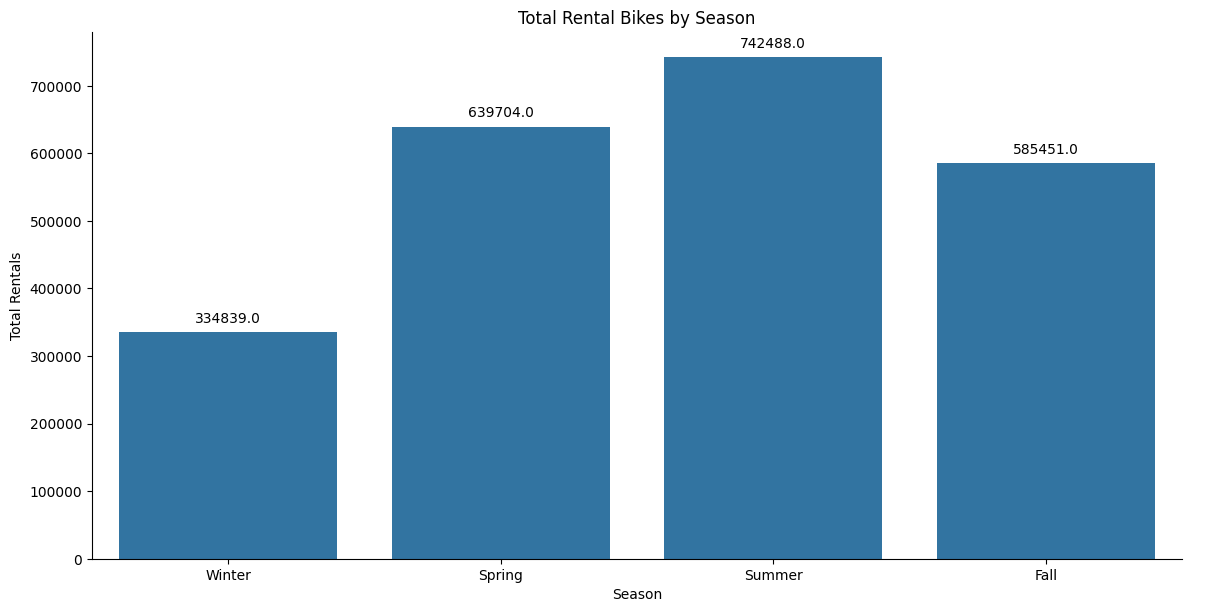

In [4]:
# Group by season
season_counts = df.groupby('season')['cnt'].sum().reset_index()

# Map the numeric values to season names
season_mapping = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
season_counts['season'] = season_counts['season'].map(season_mapping)

# Creating a categorical plot by season
g = sns.catplot(x='season', y='cnt', data=season_counts, kind='bar', height=6, aspect=2)

# Annotating the bars with the counts
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

plt.title('Total Rental Bikes by Season')
plt.xlabel('Season')
plt.ylabel('Total Rentals')
plt.show()

We can see from the data that Summer is the peak season for people to go bicycling.

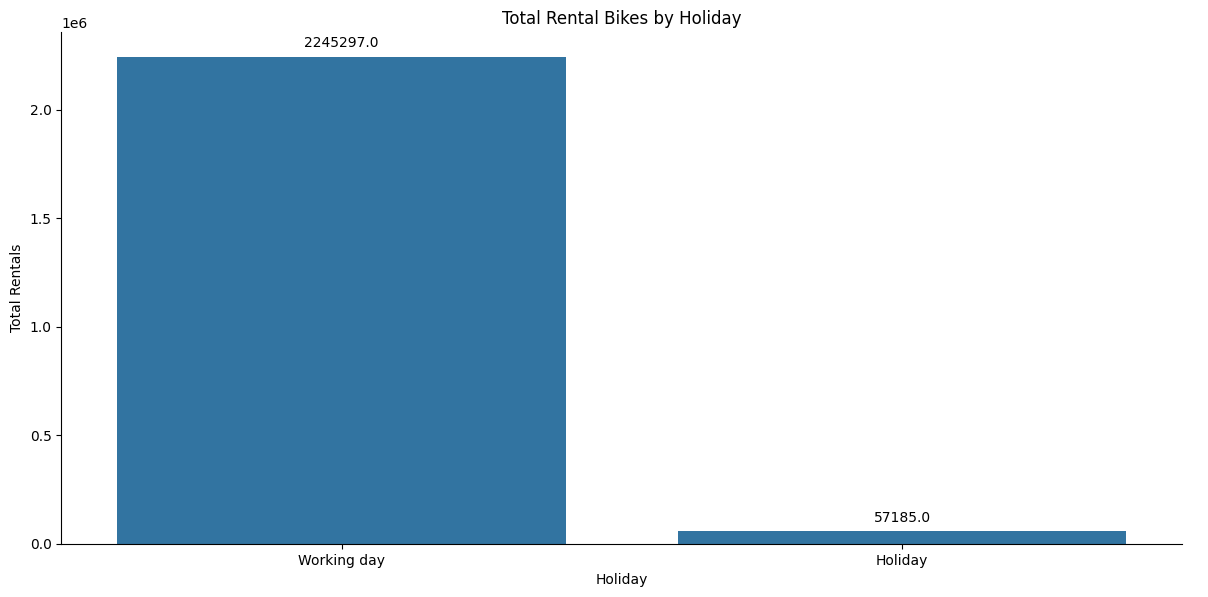

In [5]:
# Group by holiday
holiday_counts = df.groupby('holiday')['cnt'].sum().reset_index()

# Map the numeric values to holiday names
holiday_mapping = {0: 'Working day', 1: 'Holiday'}
holiday_counts['holiday'] = holiday_counts['holiday'].map(holiday_mapping)

# Creating a categorical plot by holiday
g = sns.catplot(x='holiday', y='cnt', data=holiday_counts, kind='bar', height=6, aspect=2)

# Annotating the bars with the counts
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

plt.title('Total Rental Bikes by Holiday')
plt.xlabel('Holiday')
plt.ylabel('Total Rentals')
plt.show()

The majority bike rental is for working day

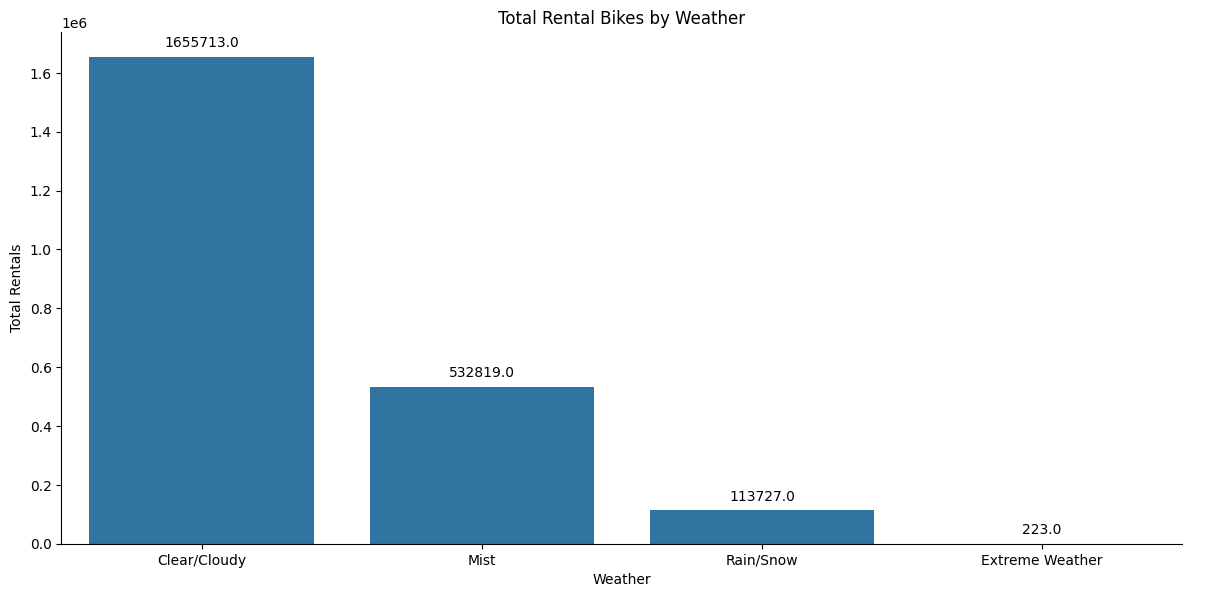

In [6]:
# Group by weathers
weathersit_counts = df.groupby('weathersit')['cnt'].sum().reset_index()

# Map the numeric values to holiday names
weathersit_mapping = {1: 'Clear/Cloudy', 2: 'Mist', 3:'Rain/Snow', 4: 'Extreme Weather'}
weathersit_counts['weathersit'] = weathersit_counts['weathersit'].map(weathersit_mapping)

# Creating a categorical plot by holiday
g = sns.catplot(x='weathersit', y='cnt', data=weathersit_counts, kind='bar', height=6, aspect=2)

# Annotating the bars with the counts
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

plt.title('Total Rental Bikes by Weather')
plt.xlabel('Weather')
plt.ylabel('Total Rentals')
plt.show()

It is clear that people tend to go for bicycling when the weather is good (the first type of weather)

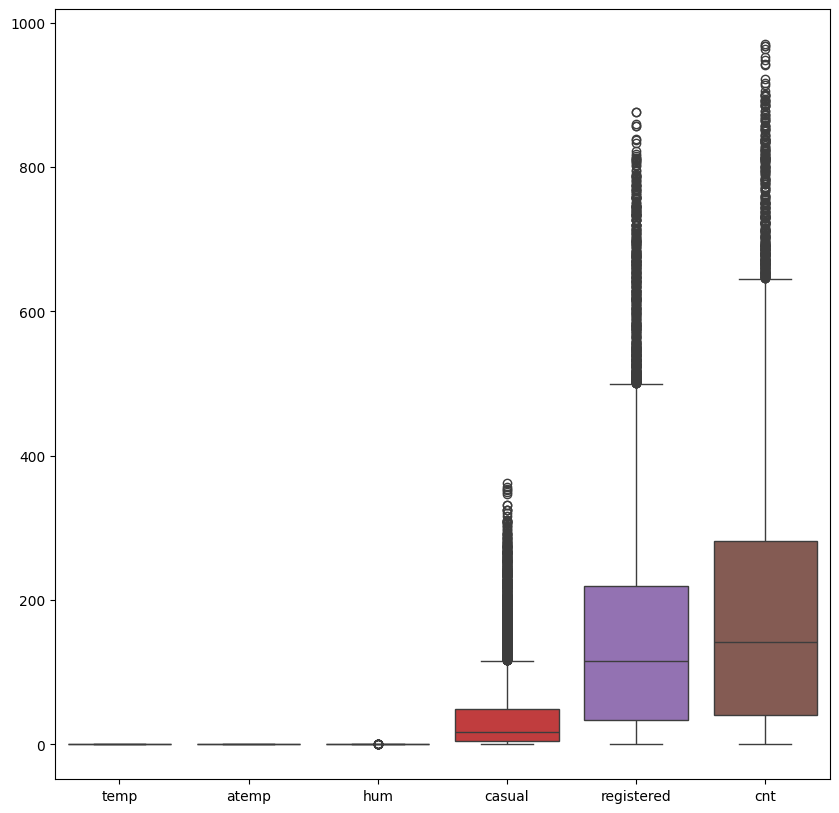

In [7]:
# Outlier data using boxplot
sns.boxplot(data=df[['temp',
       'atemp', 'hum', 'casual', 'registered', 'cnt']])
fig=plt.gcf()
fig.set_size_inches(10,10)

In [8]:
print(df.describe())

                hum    weathersit       holiday        season         atemp  \
count  12165.000000  12165.000000  12165.000000  12165.000000  12165.000000   
mean       0.625451      1.416934      0.029758      2.488615      0.476996   
std        0.192102      0.635937      0.169925      1.106157      0.171857   
min        0.000000      1.000000      0.000000      1.000000      0.000000   
25%        0.470000      1.000000      0.000000      2.000000      0.333300   
50%        0.620000      1.000000      0.000000      2.000000      0.484800   
75%        0.780000      2.000000      0.000000      3.000000      0.621200   
max        1.000000      4.000000      1.000000      4.000000      1.000000   

               temp            hr        casual    registered           cnt  
count  12165.000000  12165.000000  12165.000000  12165.000000  12165.000000  
mean       0.498185     11.519770     35.834443    153.436580    189.271023  
std        0.192492      6.931872     49.489286    151

1. Humidity (hum)
    Mean: 0.63

    Min-Max Range: 0.00 - 1.00

    The average normalized humidity is 0.63, with values spanning the entire possible range (0 to 1). This suggests a wide variation in humidity levels experienced by users.

2. Weather Situation (weathersit)
    Mean: 1.42

    Mode: 1 (since 1 is the value at the 50th percentile)

    The majority of the time, the weather is relatively clear (Category 1). Higher categories, indicating worse weather conditions, are less frequent.

3. Holiday (holiday)
    Mean: 0.03

    Min-Max Range: 0 - 1

    Holidays are quite rare, comprising about 3% of the days in the dataset.

4. Season (season)
    Mean: 2.49

    Min-Max Range: 1 - 4

    The dataset covers all four seasons fairly evenly, with no single season dominating.

5. Apparent Temperature (atemp)
    Mean: 0.48

    Min-Max Range: 0.00 - 1.00

    The normalized apparent temperature averages around 0.48, indicating moderate perceived temperatures, but it spans the entire possible range.

6. Actual Temperature (temp)
    Mean: 0.50

    Min-Max Range: 0.02 - 1.00

    The actual temperature has a mean close to the midpoint of the range, suggesting a balance between cooler and warmer days.

7. Hour of the Day (hr)
    Mean: 11.52

    Min-Max Range: 0 - 23

    This dataset covers all hours of the day, with a mean value suggesting balanced data collection throughout the day.

8. Casual Users (casual)
    Mean: 35.83

    Min-Max Range: 0 - 362

    On average, there are about 36 casual users per hour, but this can vary significantly, with some hours seeing as few as zero and others as many as 362.

9. Registered Users (registered)
    Mean: 153.44

    Min-Max Range: 0 - 876

    There is a significantly higher average number of registered users compared to casual users, suggesting a strong base of regular customers.

10. Total Rentals (cnt)
    Mean: 189.27

    Min-Max Range: 1 - 970

    The total bike rentals per hour have a wide range, with an average of about 189. This indicates variability in demand, potentially influenced by factors such as time of day, weather, and season.

Summary
- The data shows a broad range of weather conditions, temperatures, and humidity levels.

- There are distinct differences in the number of casual versus registered users, with registered users being more consistent.

- Total rentals show significant variation, likely influenced by a combination of factors such as season, weather, and time of day.

In [9]:
#Changing column names
column_mapping = {'dteday': 'date', 'yr': 'year', 'temp': 'temperature', 'hum': 'humidity','cnt': 'total'}

# Use the rename method to rename the columns
df.rename(columns=column_mapping, inplace=True)
df.head()

,date,humidity,weathersit,holiday,season,atemp,temperature,hr,casual,registered,total
0,2011-12-09,0.62,1,0,4,0.3485,0.36,16,24,226,250
1,2012-06-17,0.64,1,0,2,0.5152,0.54,4,2,16,18
2,2011-06-15,0.53,1,0,2,0.6212,0.62,23,17,90,107
3,2012-03-31,0.87,2,0,2,0.3485,0.36,8,19,126,145
4,2012-07-31,0.55,1,0,3,0.6970,0.76,18,99,758,857


In [10]:
# Convert the 'dteday' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract day, month, and year into separate columns
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Drop the original datetime
df = df.drop(columns=['date'])

# Display the updated DataFrame
print(df.head())

   humidity  weathersit  holiday  season   atemp  temperature  hr  casual  \
0      0.62           1        0       4  0.3485         0.36  16      24   
1      0.64           1        0       2  0.5152         0.54   4       2   
2      0.53           1        0       2  0.6212         0.62  23      17   
3      0.87           2        0       2  0.3485         0.36   8      19   
4      0.55           1        0       3  0.6970         0.76  18      99   

   registered  total  day  month  year  
0         226    250    9     12  2011  
1          16     18   17      6  2012  
2          90    107   15      6  2011  
3         126    145   31      3  2012  
4         758    857   31      7  2012  


<Axes: >

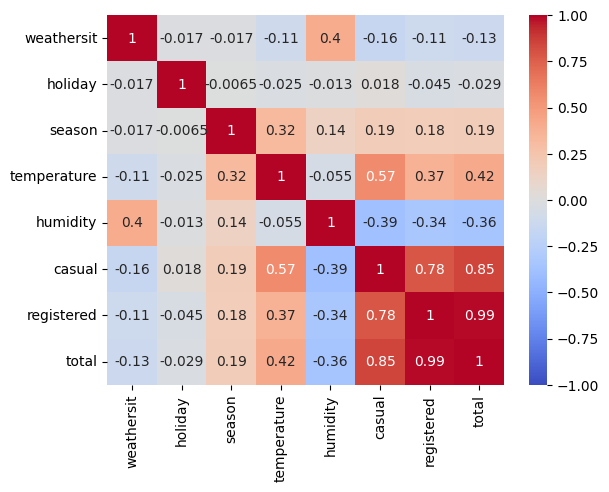

In [11]:
#Creating heatmap for correlations between weather related variables and count of rides:
variable_df = df[['weathersit', 'holiday', 'season','temperature','humidity','casual','registered','total']]

corr_matrix = variable_df.corr(numeric_only=True, method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

The correlation between variable 'Casual' and 'Registered' is 0.78 which means between two independent variables, this high correlation means 'Casual' and 'Registered' are the same, so we will combine it to 'Total'

Untuk variable independen yang korelasinya tinggi menandakan salah satu variable bisa terduplikasi.Jadi bisa di takeout

1. Cari korelasi antara independen variable yang rendah
2. Cek outlier untuk semua variable
3. Cek trend untuk setiap variable

   humidity  weathersit  holiday  season   atemp  temperature  hr  total  day  \
0        62           1        0       4  0.3485         0.36  16    250    9   
1        64           1        0       2  0.5152         0.54   4     18   17   
2        53           1        0       2  0.6212         0.62  23    107   15   
3        87           2        0       2  0.3485         0.36   8    145   31   
4        55           1        0       3  0.6970         0.76  18    857   31   

   month  year  
0     12  2011  
1      6  2012  
2      6  2011  
3      3  2012  
4      7  2012  


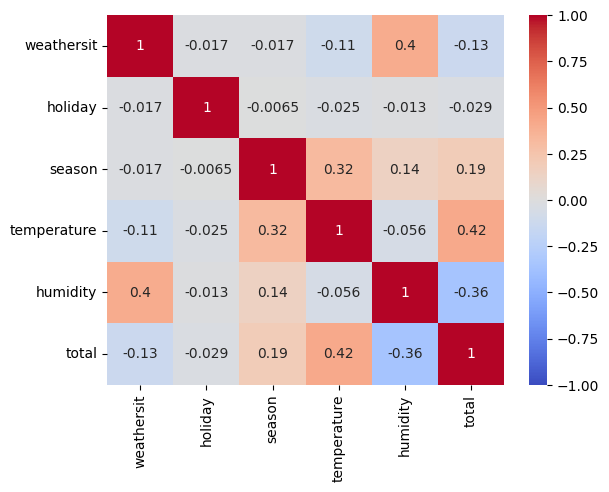

In [12]:
# Drop the original 'casual' and 'registered' columns
df = df.drop(columns=['casual', 'registered'])

# Convert 'humidity' to integers 
df['humidity'] = (df['humidity'] * 100).astype(int)

# Display the updated DataFrame
print(df.head())

# Creating heatmap for correlations between weather-related variables and count of rides
variable_df = df[['weathersit', 'holiday', 'season', 'temperature', 'humidity', 'total']]

corr_matrix = variable_df.corr(numeric_only=True, method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.show()

Analysis:
1. Holiday to other independent varibles are inversely correlated. It means good because holiday is also an independent variable 
2. Holiday to total is inversely correlated
3. Temperature to total variable have a strong correlation
4. Season to total also have a strong correlation

Text(0.5, 80, 'y = 1.123 + (377.667x)')

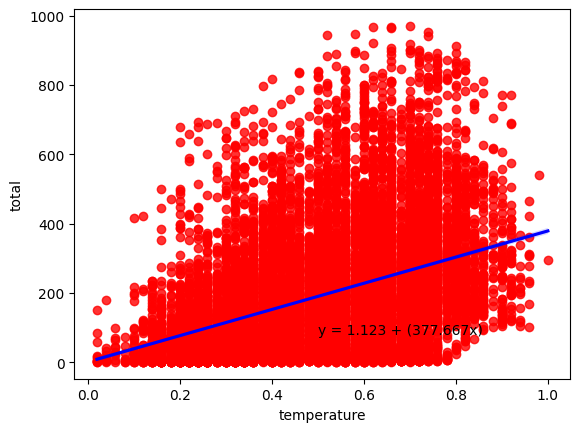

In [13]:
#The heatmap shows that there is a good correlations between total bike riding and temperature

#Now, let's check the regression correlation between Casual riding and temperature
p = sns.regplot(x='temperature', y= 'total', data=variable_df, scatter_kws={'color':'red'},
           line_kws={'color':'blue'})
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())
plt.text(0.5, 80, 'y = ' + str(round(intercept,3)) + ' + (' + str(round(slope,3)) + 'x)')

In [14]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save the training set to a CSV file
train_df.to_csv('train.csv', index=False)

# Save the testing set to a CSV file
test_df.to_csv('test.csv', index=False)

print("Data has been split and saved to 'train.csv' and 'test.csv'.")

Data has been split and saved to 'train.csv' and 'test.csv'.


In [15]:
#Data Formed and split

# Define the target variable 'y' as the 'total' column
y = df['total']

# Define the features 'X' by dropping the target column and any other columns you don't need
X = df.drop(columns=['total'])

# Display the shapes of X and y to confirm
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (12165, 10)
Target shape: (12165,)


In [16]:
# Read the CSV file
train_data = 'C:\\capstoneproject3\\train.csv'
train = pd.read_csv(train_data)
train.head()

,humidity,weathersit,holiday,season,atemp,temperature,hr,total,day,month,year
0,83,3,0,3,0.5758,0.62,20,241,25,8,2012
1,62,1,0,1,0.4394,0.44,1,18,24,2,2012
2,51,1,0,1,0.2273,0.22,3,1,5,3,2012
3,35,1,0,3,0.7879,0.88,18,339,30,6,2012
4,79,1,0,3,0.6970,0.72,2,8,6,9,2012


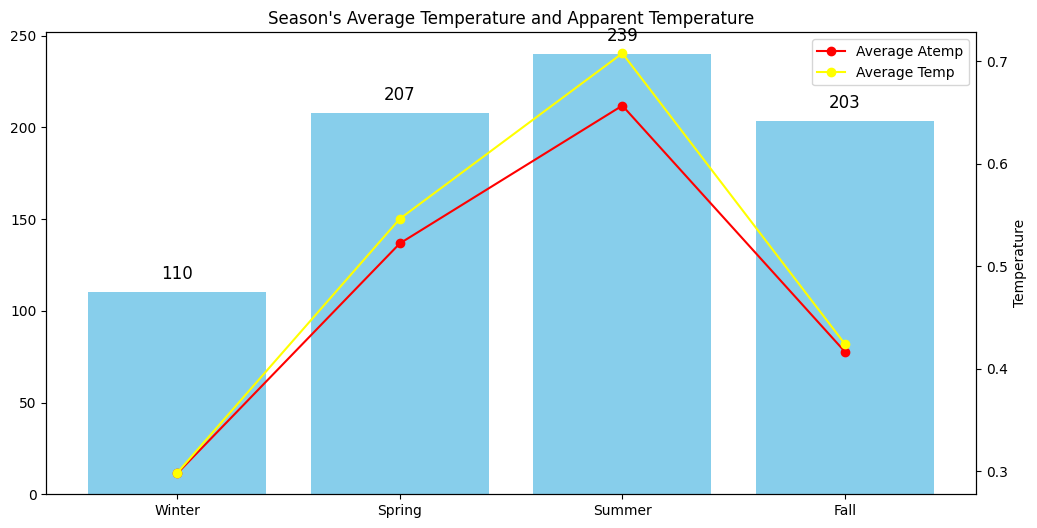

In [17]:
# Example data
x = ["Winter", "Spring", "Summer", "Fall"]
y, y1, y2 = [], [], []
for i in range(1, 5):
    y.append(np.mean(train[train["season"] == i]["temperature"].values.tolist()))
    y1.append(np.mean(train[train["season"] == i]["atemp"].values.tolist()))
    y2.append(np.mean(train[train["season"] == i]["total"].values.tolist()))

plt.figure(figsize=(12, 6))  # Adjusted the figure size

# Bar plot for total counts
plt.bar(x, y2, color="skyblue", label="Total Count")
for i in range(len(x)):
    height = y2[i]
    plt.text(x[i], height + 5, '%d' % height, ha='center', va='bottom', size=12)

# Line plot for average temperature and apparent temperature
ay1 = plt.twinx()
ay1.plot(x, y1, color="red", label="Average Atemp", marker='o')
ay1.plot(x, y, color='yellow', label="Average Temp", marker='o')

# Adding titles and labels
plt.title("Season's Average Temperature and Apparent Temperature")
plt.xlabel("Season")
plt.ylabel("Total Count")
ay1.set_ylabel("Temperature")

# Adding legends
plt.legend(loc='upper left')
ay1.legend(loc='upper right')

plt.show()

Describe
The temperature changes a lot with the seasons. In other words, weather and temperature have a direct relationship, and the graph above is the result of visualizing the relationship between the two factors and the analysis of how much the seasonal (average temperature by season) bicycle loan exists.
As you can see from the graph, when summer is coming to an end in autumn and winter is coming, the weather is considered the warmest and most suitable day, and when that happens, the most utilization rate is recorded.

<BarContainer object of 12 artists>

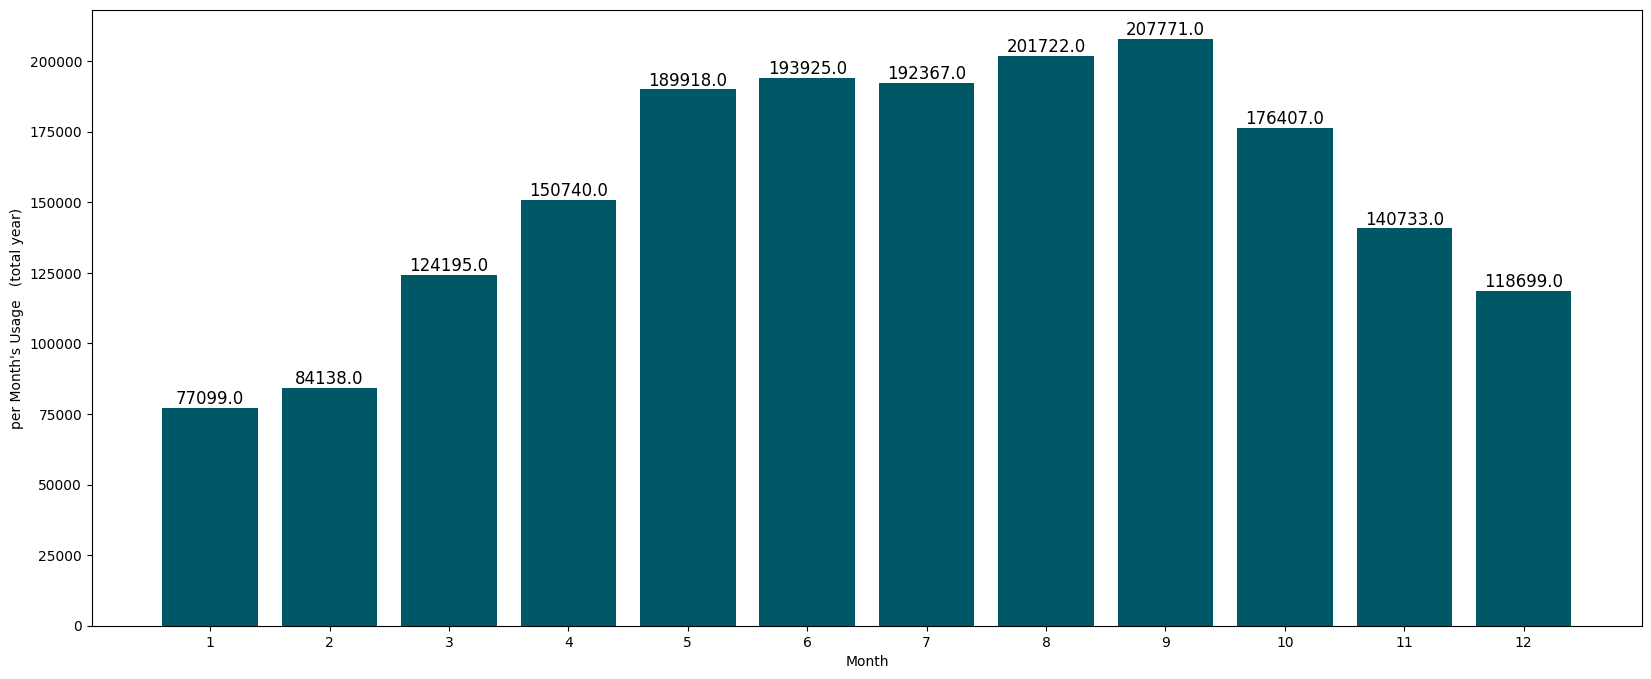

In [18]:
x = ["1","2","3","4","5","6","7","8","9","10","11","12"]
y = []
for i in range(1,13):
    y.append(train[train["month"]==i]["total"].sum())
plt.figure(figsize=(20,8))
for i in range(len(x)):
    height = y[i]
    plt.text(x[i], height + 1.9, '%.1f' %height, ha='center', va='bottom', size = 12)
plt.title("")
plt.xlabel("Month")
plt.ylabel("per Month's Usage   (total year)")
plt.bar(x,y,color = '#005766')

Describe
As in the previous seasonal demand analysis, when comparing monthly demand, it is confirmed that the amount of loans during the fall period is the highest, and among them, the amount of loans during the period between summer and autumn is the highest.

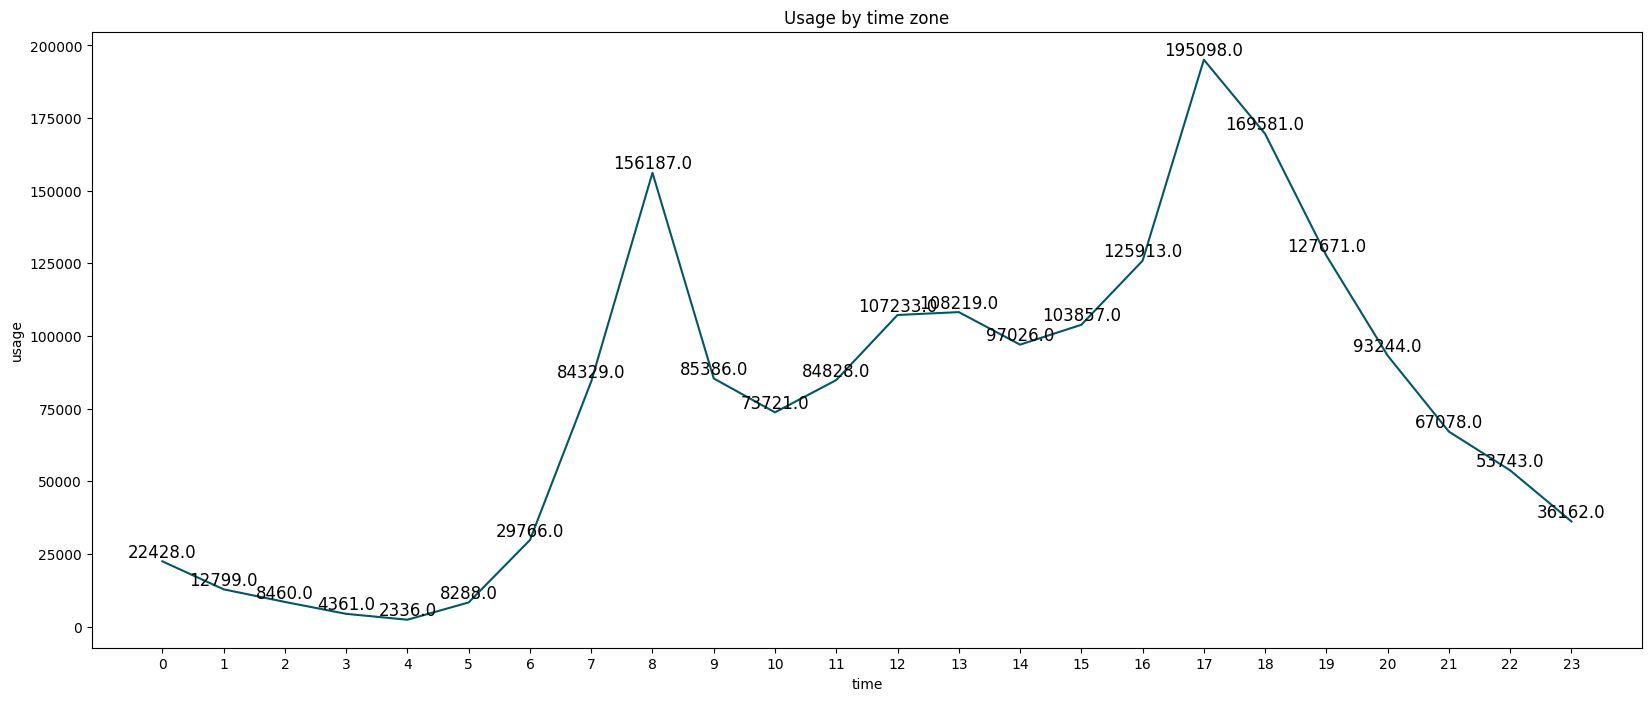

In [19]:
for i in range(24):
    y.append(train[train["hr"]==i]["total"].sum())

x = []
for i in range(24):
    x.append(str(i))
y = []
for i in range(24):
    y.append(train[train["hr"]==i]["total"].sum())
plt.figure(figsize=(20,8))
for i in range(len(x)):
    height = y[i]
    plt.text(x[i], height + 1.9, '%.1f' %height, ha='center', va='bottom', size = 12)
plt.title("Usage by time zone")
plt.xlabel("time")
plt.ylabel("usage")
plt.plot(x,y,color = '#005766')

Describe
Through the graph above, the usage is high from 7a.m -9 a.m. and 4 p.m -7 p.m.
It can be predicted that this situation is usually rented during rush hour and rush hour. If so, the elements of the holiday may also have a significant correlation with the results. First of all, I would like to analyze the correlation between the two through data macroization.

<Axes: xlabel='count', ylabel='Density'>

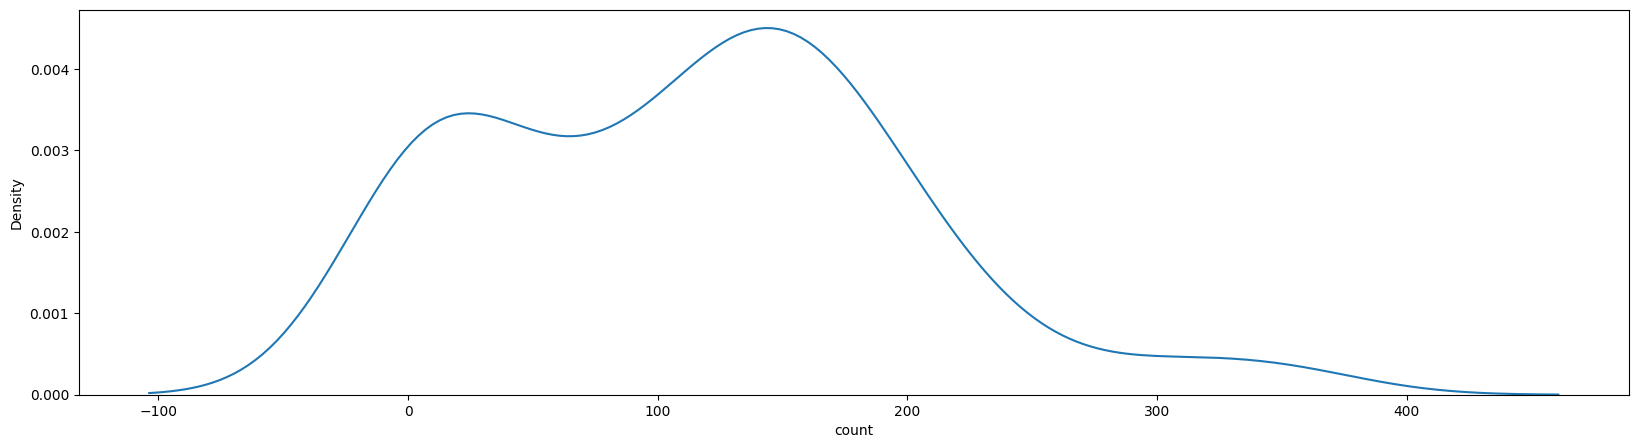

In [20]:
train["humidity"].value_counts().sort_index()

plt.figure(figsize=(20,5))
sns.kdeplot(train["humidity"].value_counts().sort_index())

Since it is a data format of various and irregular patterns, it is necessary to add efficiency to visualization and machine learning analysis through mapping.

Data mapping Introduction
Data mapping is a process in data analysis that involves transforming data from one form or structure to another in order to better understand and analyze it. The transformed data is then often visualized to facilitate exploration and understanding of relationships and patterns. The importance of data mapping lies in its ability to reveal insights and patterns that might not be immediately apparent in raw data, and to facilitate communication of these insights to others.
In data analysis, data mapping can be used to transform and prepare data for analysis, to create visualizations that help to understand relationships between variables, and to identify trends and patterns in the data. For example, geographical data can be mapped to help understand patterns and trends in data across different regions. By visualizing the data in this way, data mapping can help to reveal hidden insights and inform decision-making.

Additionally, data mapping can be an effective tool for communicating complex data and insights to a wider audience. Visualizing data on a map can make it easier for non-technical stakeholders to understand and engage with the data, which can help to drive action and impact.

Overall, data mapping is an important step in the data analysis process, as it enables data to be transformed and visualized in a way that supports exploration, analysis, and communication of insights.

mapping description
Here, I divided the data into a total of 10 types. Data were classified into 10 units, and the average value of each unit was set as a representative value.

I thought that setting the result value obtained through the training data would be more useful in terms of result accuracy, so I set the value according to the training data.
Since the above calculation is an average value obtained based on the test data, it is a good method to set and substitute an appropriate value according to individual judgment.

In [21]:
mapping1_10 = []
mapping10_20 = []
mapping20_30 = []
mapping30_40 = []
mapping40_50 = []
mapping50_60 = []
mapping60_70 = []
mapping70_80 = []
mapping80_90 = []
mapping90_100 = []
for i in range(len(train["humidity"].value_counts())):
    dd = []
    if 1 <= train["humidity"].value_counts().sort_index().index[i] < 10:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping1_10.append(train["humidity"].value_counts().sort_index().index[i])
    elif 10<= train["humidity"].value_counts().sort_index().index[i] < 20:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping10_20.append(train["humidity"].value_counts().sort_index().index[i])    
    elif 20<= train["humidity"].value_counts().sort_index().index[i] < 30:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping20_30.append(train["humidity"].value_counts().sort_index().index[i])
    elif 30<= train["humidity"].value_counts().sort_index().index[i] < 40:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping30_40.append(train["humidity"].value_counts().sort_index().index[i])    
    elif 40<= train["humidity"].value_counts().sort_index().index[i] < 50:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping40_50.append(train["humidity"].value_counts().sort_index().index[i])
    elif 50<= train["humidity"].value_counts().sort_index().index[i] < 60:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping50_60.append(train["humidity"].value_counts().sort_index().index[i])    
    elif 60<= train["humidity"].value_counts().sort_index().index[i] < 70:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping60_70.append(train["humidity"].value_counts().sort_index().index[i])
    elif 70<= train["humidity"].value_counts().sort_index().index[i] < 80:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping70_80.append(train["humidity"].value_counts().sort_index().index[i])
    elif 80<= train["humidity"].value_counts().sort_index().index[i] < 90:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping80_90.append(train["humidity"].value_counts().sort_index().index[i])
    elif 90<= train["humidity"].value_counts().sort_index().index[i] < 100:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping90_100.append(train["humidity"].value_counts().sort_index().index[i])

In [22]:
mapping_list_1 = [mapping1_10,mapping10_20,mapping20_30,mapping30_40,
                 mapping40_50,mapping50_60,mapping60_70,mapping70_80
                 ,mapping80_90,mapping90_100]

for i in mapping_list_1:
    print(int(np.mean(i)))

8
17
25
35
44
54
64
74
84
93


In [23]:
for i in range(len(train["humidity"].values)):
    if 1<= train["humidity"].values[i] < 10:
        train["humidity"].values[i] = 8
    elif 10<= train["humidity"].values[i] < 20:
        train["humidity"].values[i] = 16
    elif 20<= train["humidity"].values[i] < 30:
        train["humidity"].values[i] = 25
    elif 30<= train["humidity"].values[i] < 40:
        train["humidity"].values[i] = 35
    elif 40<= train["humidity"].values[i] < 50:
        train["humidity"].values[i] = 44
    elif 50<= train["humidity"].values[i] < 60:
        train["humidity"].values[i] = 54
    elif 60<= train["humidity"].values[i] < 70:
        train["humidity"].values[i] = 64
    elif 70<= train["humidity"].values[i] < 80:
        train["humidity"].values[i] = 74
    elif 80<= train["humidity"].values[i] < 90:
        train["humidity"].values[i] = 85
    elif 90<= train["humidity"].values[i] < 100:
        train["humidity"].values[i] = 93

In [24]:
train["humidity"].value_counts().sort_index()

humidity
0        11
8         1
16       31
25      346
35      881
44     1518
54     1625
64     1569
74     1511
85     1591
93      500
100     148
Name: count, dtype: int64

In [25]:
# Read the CSV file
test_data = 'C:\\capstoneproject3\\test.csv'
test = pd.read_csv(test_data)
test.head()

,humidity,weathersit,holiday,season,atemp,temperature,hr,total,day,month,year
0,66,1,0,4,0.3182,0.34,7,43,13,11,2011
1,53,2,0,4,0.3636,0.36,4,4,20,12,2011
2,81,1,0,4,0.3030,0.26,2,62,4,12,2011
3,83,1,0,2,0.5455,0.58,21,177,16,5,2011
4,83,1,0,2,0.5152,0.54,22,172,12,5,2011


In [26]:
# Map the test data

mapping1_10 = []
mapping10_20 = []
mapping20_30 = []
mapping30_40 = []
mapping40_50 = []
mapping50_60 = []
mapping60_70 = []
mapping70_80 = []
mapping80_90 = []
mapping90_100 = []
for i in range(len(test["humidity"].value_counts())):
    dd = []
    if 1 <= test["humidity"].value_counts().sort_index().index[i] < 10:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping1_10.append(test["humidity"].value_counts().sort_index().index[i])
    elif 10<= test["humidity"].value_counts().sort_index().index[i] < 20:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping10_20.append(test["humidity"].value_counts().sort_index().index[i])    
    elif 20<= test["humidity"].value_counts().sort_index().index[i] < 30:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping20_30.append(test["humidity"].value_counts().sort_index().index[i])
    elif 30<= test["humidity"].value_counts().sort_index().index[i] < 40:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping30_40.append(test["humidity"].value_counts().sort_index().index[i])    
    elif 40<= test["humidity"].value_counts().sort_index().index[i] < 50:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping40_50.append(test["humidity"].value_counts().sort_index().index[i])
    elif 50<= test["humidity"].value_counts().sort_index().index[i] < 60:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping50_60.append(test["humidity"].value_counts().sort_index().index[i])    
    elif 60<= test["humidity"].value_counts().sort_index().index[i] < 70:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping60_70.append(test["humidity"].value_counts().sort_index().index[i])
    elif 70<= test["humidity"].value_counts().sort_index().index[i] < 80:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping70_80.append(test["humidity"].value_counts().sort_index().index[i])
    elif 80<= test["humidity"].value_counts().sort_index().index[i] < 90:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping80_90.append(test["humidity"].value_counts().sort_index().index[i])
    elif 90<= test["humidity"].value_counts().sort_index().index[i] < 100:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping90_100.append(test["humidity"].value_counts().sort_index().index[i])

mapping_list_1 = [mapping10_20,mapping20_30,mapping30_40,
                 mapping40_50,mapping50_60,mapping60_70,mapping70_80
                 ,mapping80_90,mapping90_100]

for i in mapping_list_1:
#     print(i)
    print(int(np.mean(i)))

16
25
35
44
54
64
74
84
93


In [27]:
for i in range(len(test["humidity"].values)):
    if 10<= test["humidity"].values[i] < 20:
        test["humidity"].values[i] = 16
    elif 20<= test["humidity"].values[i] < 30:
        test["humidity"].values[i] = 25
    elif 30<= test["humidity"].values[i] < 40:
        test["humidity"].values[i] = 35
    elif 40<= test["humidity"].values[i] < 50:
        test["humidity"].values[i] = 44
    elif 50<= test["humidity"].values[i] < 60:
        test["humidity"].values[i] = 54
    elif 60<= test["humidity"].values[i] < 70:
        test["humidity"].values[i] = 64
    elif 70<= test["humidity"].values[i] < 80:
        test["humidity"].values[i] = 74
    elif 80<= test["humidity"].values[i] < 90:
        test["humidity"].values[i] = 85
    elif 90<= test["humidity"].values[i] < 100:
        test["humidity"].values[i] = 93

<BarContainer object of 12 artists>

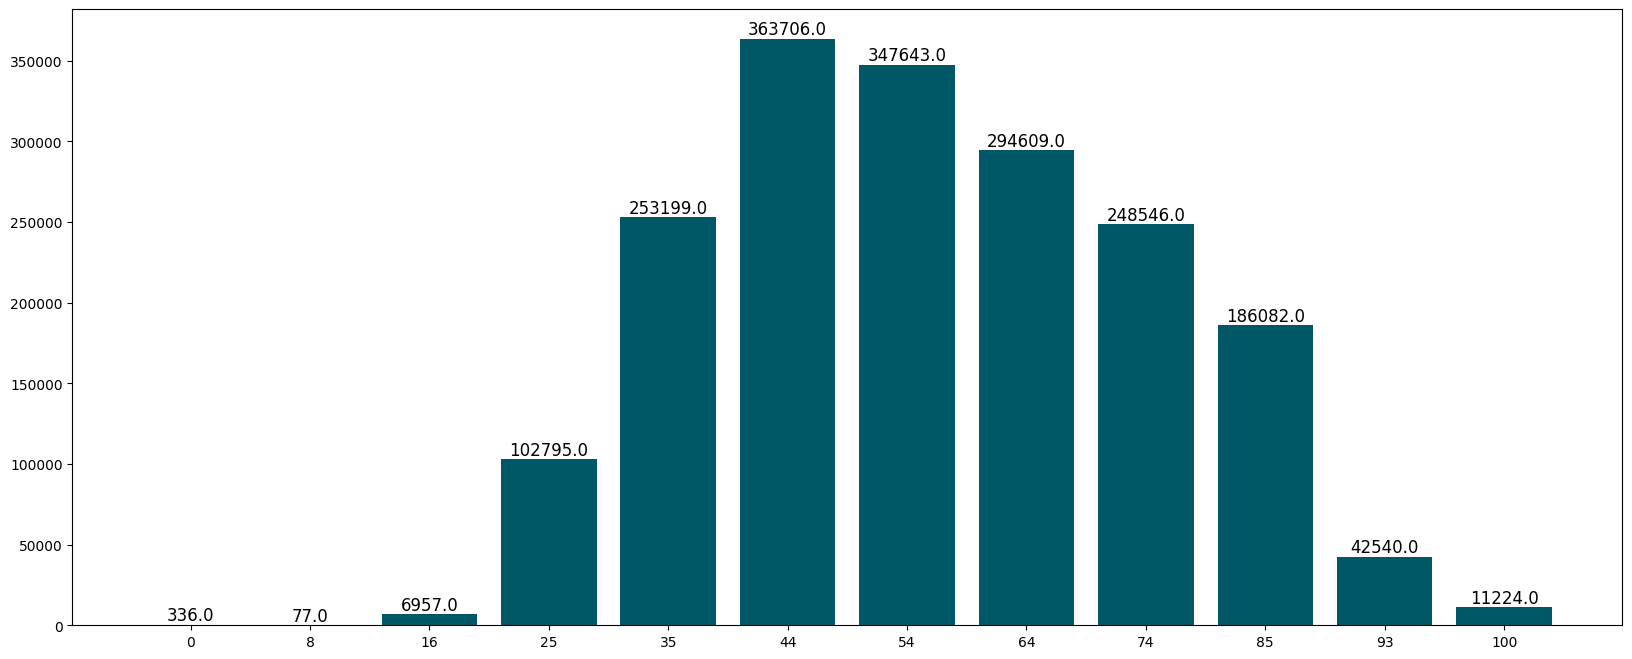

In [28]:
y = (train[train["humidity"]==0]["total"].sum(),
train[train["humidity"]==8]["total"].sum(),
train[train["humidity"]==16]["total"].sum(),
train[train["humidity"]==25]["total"].sum(),
train[train["humidity"]==35]["total"].sum(),
train[train["humidity"]==44]["total"].sum(),
train[train["humidity"]==54]["total"].sum(),
train[train["humidity"]==64]["total"].sum(),
train[train["humidity"]==74]["total"].sum(),
train[train["humidity"]==85]["total"].sum(),
train[train["humidity"]==93]["total"].sum(),
train[train["humidity"]==100]["total"].sum())

x = ["0","8","16","25","35","44","54","64","74","85","93","100"]
plt.figure(figsize=(20,8))
for i in range(len(x)):
    height = y[i]
    plt.text(x[i], height + 1.9, '%.1f' %height, ha='center', va='bottom', size = 12)


plt.bar(x,y,color = '#005766')

In [29]:
features = ["humidity", "weathersit", "holiday", "season", "atemp", "temperature", "hr", "total", "day", "year", "month"]
x_train = train[features]
x_test = test[features]
y_train = train["total"]

When the average humidity is about 44, it can be seen that the bicycle loan is the highest.

Model Preparation for deep learning regression model

In [30]:
# Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=1,activation="linear"))

# # Compile the model with a mean squared error loss function
# model.compile(optimizer='adam', loss='mean_squared_error')

# Compile the model with a mean squared error loss function and L2 regularization
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model on the train data
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, epochs=200, verbose = 0)

# Predict the values of y for the test data
y_pred = model.predict(test)
print("Predicted y values:", y_pred)

# # Evaluate the model's performance on the test data
# test_loss = model.evaluate(x_test)
# print("Test loss:", test_loss)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predicted y values: [[339.50665]
 [327.74496]
 [343.59213]
 ...
 [350.3273 ]
 [336.84555]
 [465.30127]]


In [31]:
deep_learning_prediction = np.array(y_pred)

In [32]:
#Create a Machine Learning Model

In [33]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

k_fold = KFold(n_splits = 10, shuffle = True , random_state = 0)

In [34]:
cbr = CatBoostRegressor(verbose=0)
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
rfr = RandomForestRegressor()

model_list = [cbr,xgbr,rfr]
model_score = []
for model in model_list:
    model.fit(x_train,y_train)
    model_score.append(model.score(x_train,y_train))
model_score

[0.9999150404339677, 0.999959409236908, 0.9999996134320039]

<BarContainer object of 3 artists>

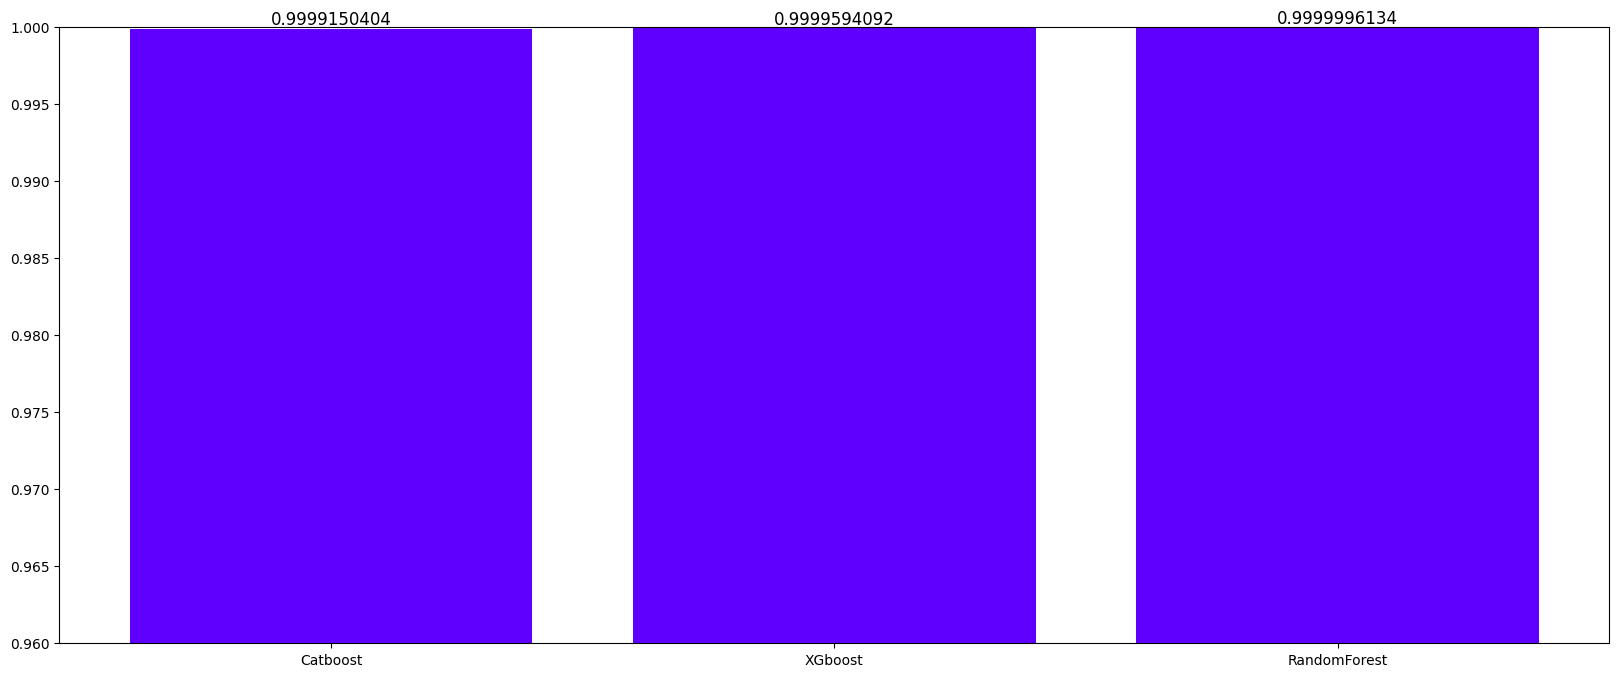

In [35]:
model_name = ["Catboost","XGboost","RandomForest"]
plt.figure(figsize=(20,8))
x = model_name
y = model_score
for i in range(len(x)):
    height = y[i]
    plt.text(x[i], height, '%.10f' %height, ha='center', va='bottom', size = 12)
plt.ylim(0.96,1)
plt.bar(x,y,color='#5F00FF')

relation_square :  0.9999992478797329


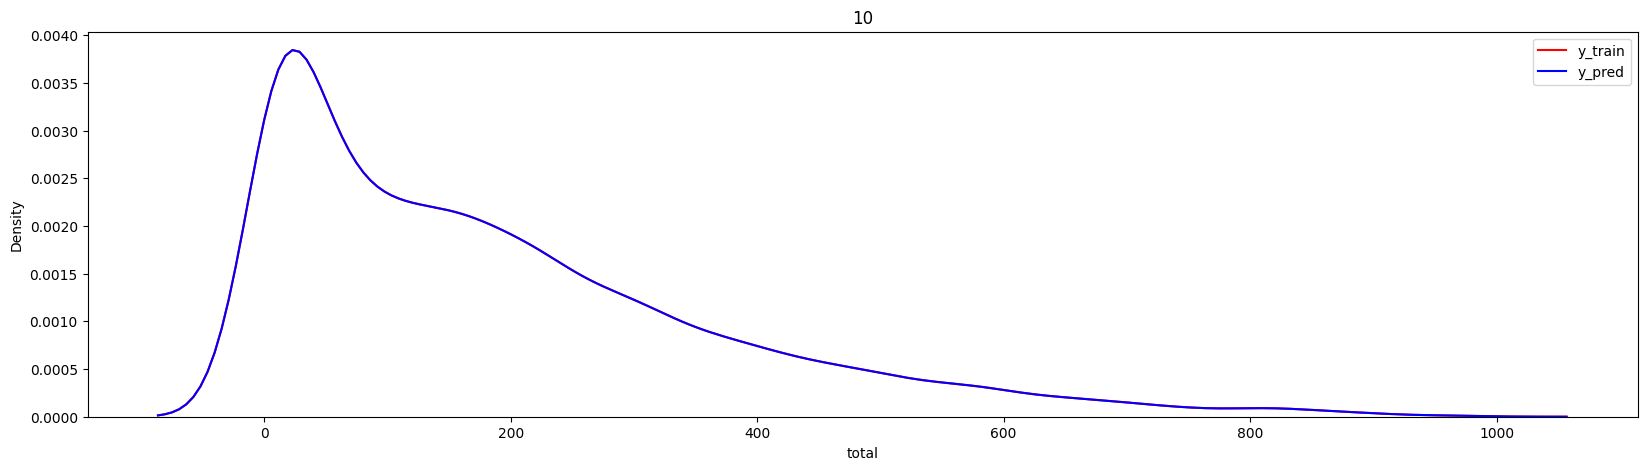

relation_square :  0.9999994104182575


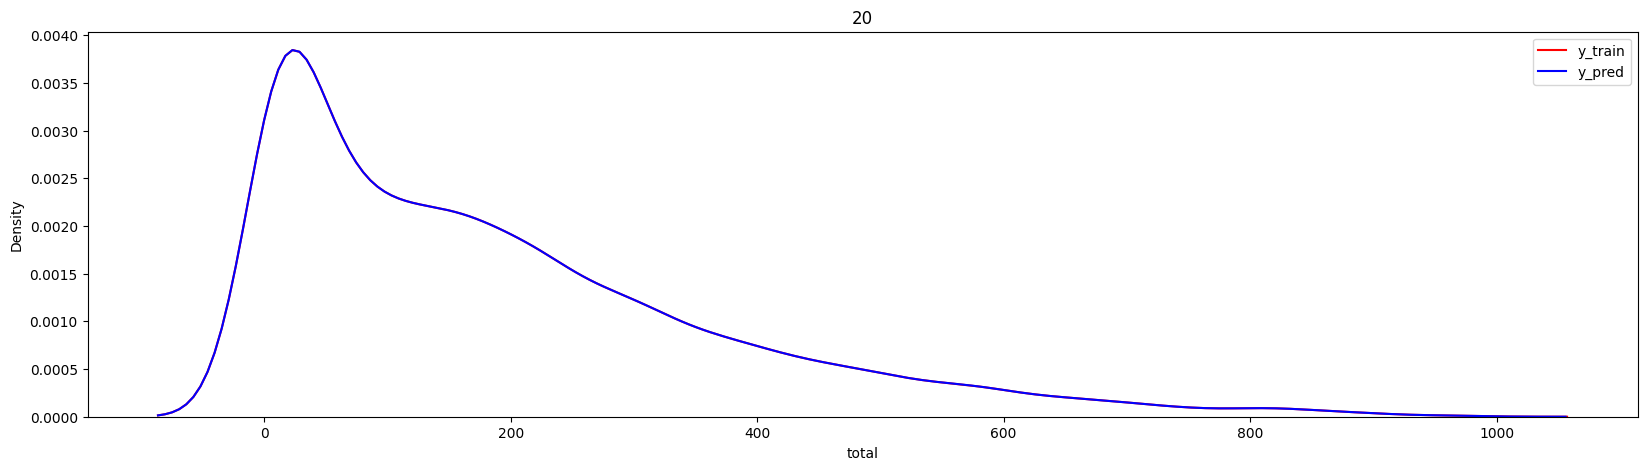

relation_square :  0.99999943491902


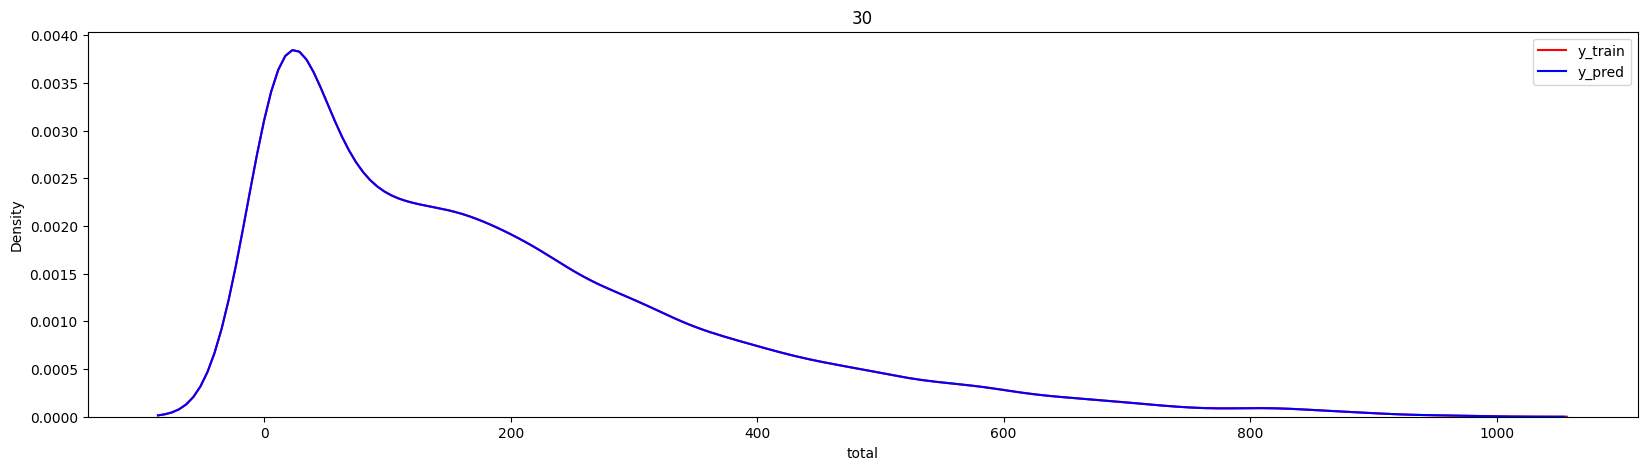

relation_square :  0.9999995138351805


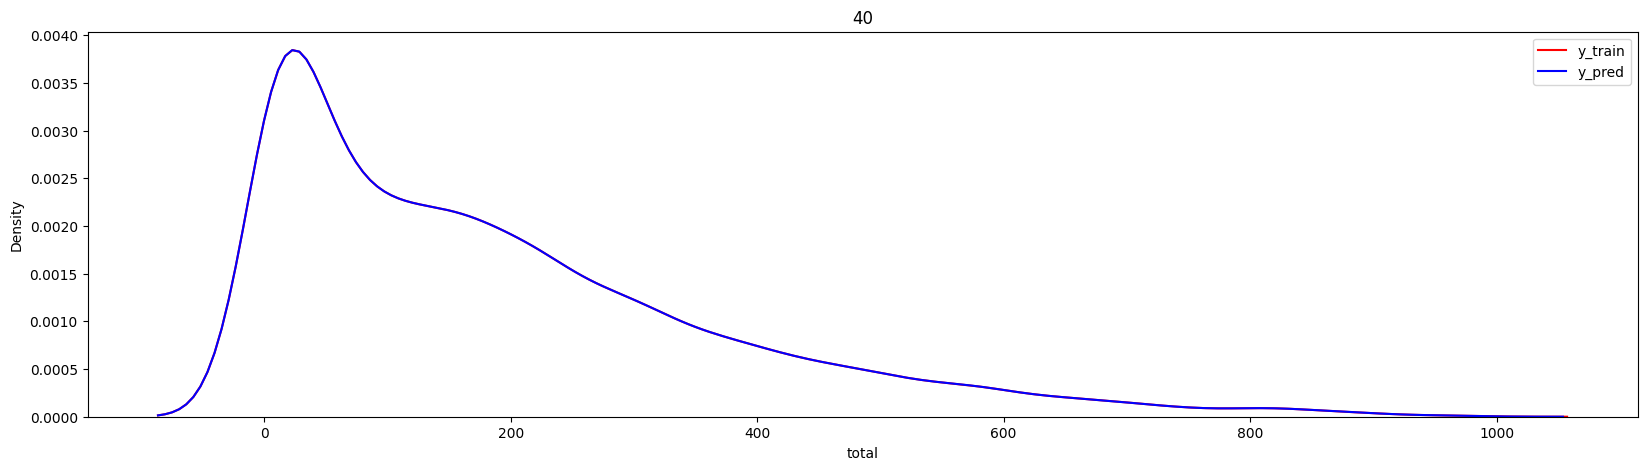

relation_square :  0.9999996398328657


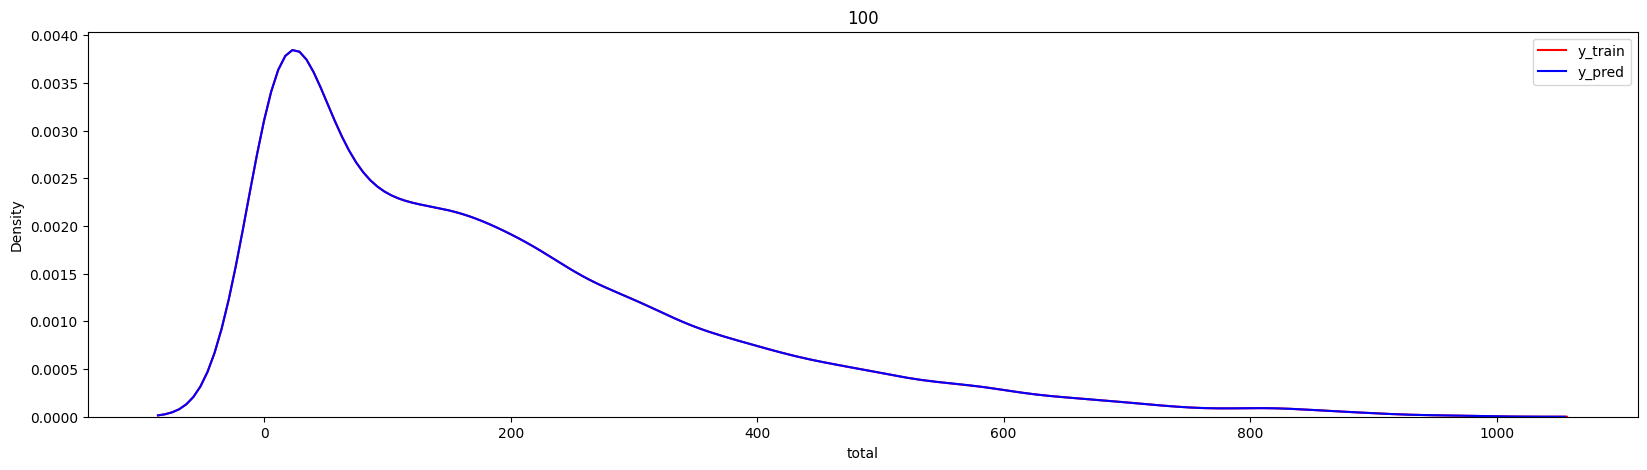

relation_square :  0.9999996455694286


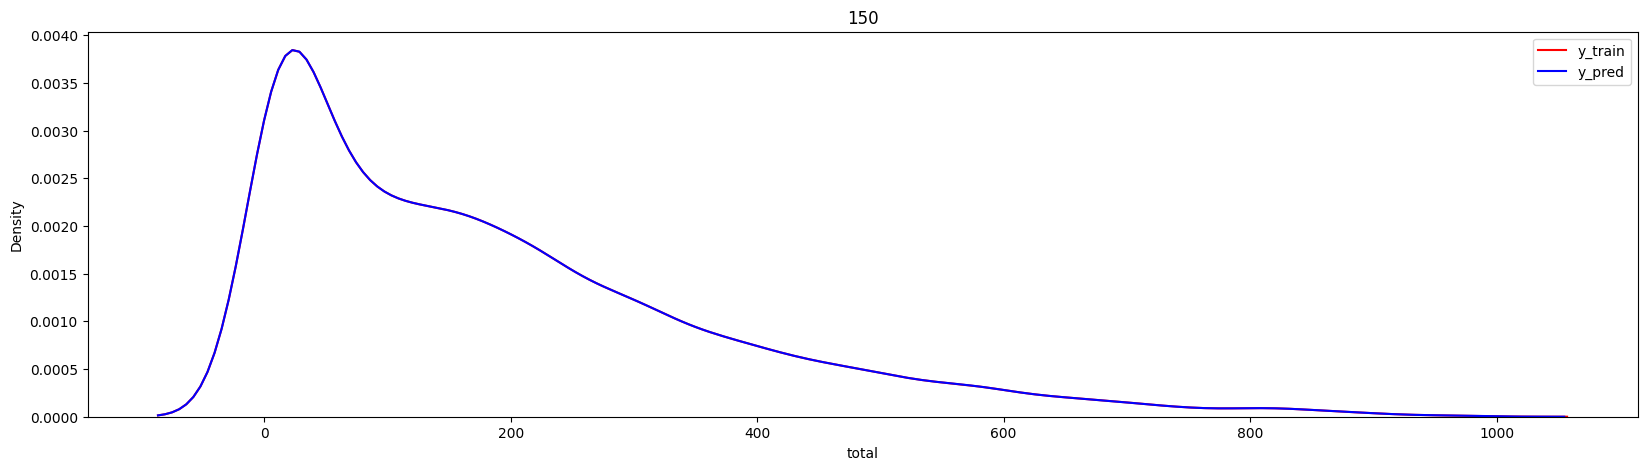

relation_square :  0.9999996611731269


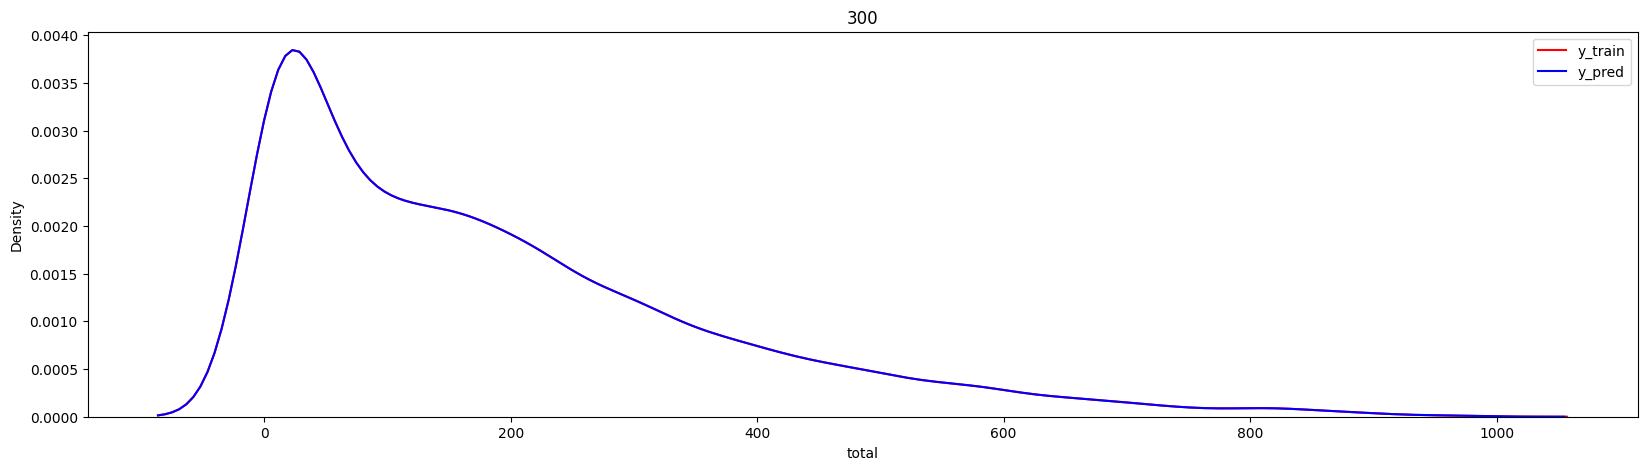

In [36]:
from sklearn.ensemble import RandomForestRegressor
# Check the result according to "n_estimators".
for i in (10, 20, 30, 40, 100, 150,300):
    model = RandomForestRegressor(n_estimators= i,n_jobs= -1, random_state = 15)
    model.fit(x_train,y_train)
    # The higher the "n_estimators" value, the higher the accuracy, 
    # but the more computational it takes for the computer to calculate and derive results. 
    # I set the value to 300 appropriately.

    relation_square = model.score(x_train, y_train)
    print('relation_square : ', relation_square)
    plt.figure(figsize=(20,5))
    y_p = model.predict(x_train)
    ax1 = sns.kdeplot(y_train,label = 'y_train',color="red")
    ax2 = sns.kdeplot(y_p,label = 'y_pred',color="blue")
    
    plt.title(i)
    plt.legend()
    plt.show()

In [37]:
model = RandomForestRegressor(n_estimators=300, n_jobs = -1 , random_state = 0)
model.fit(x_train, y_train)

predictions = model.predict(x_test)
predictions

array([ 43.        ,   4.        ,  62.        , ...,  81.        ,
        21.        , 426.81333333])

In [38]:
machine_learning_prediction = predictions

In [39]:
machine_learning_prediction

array([ 43.        ,   4.        ,  62.        , ...,  81.        ,
        21.        , 426.81333333])

In [40]:
deep_learning_prediction1 = []
for i in range(len(deep_learning_prediction)):
    deep_learning_prediction1.append(deep_learning_prediction[i][0])
deep_learning_prediction1 = np.array(deep_learning_prediction1)
deep_learning_prediction1

array([339.50665, 327.74496, 343.59213, ..., 350.3273 , 336.84555,
       465.30127], dtype=float32)

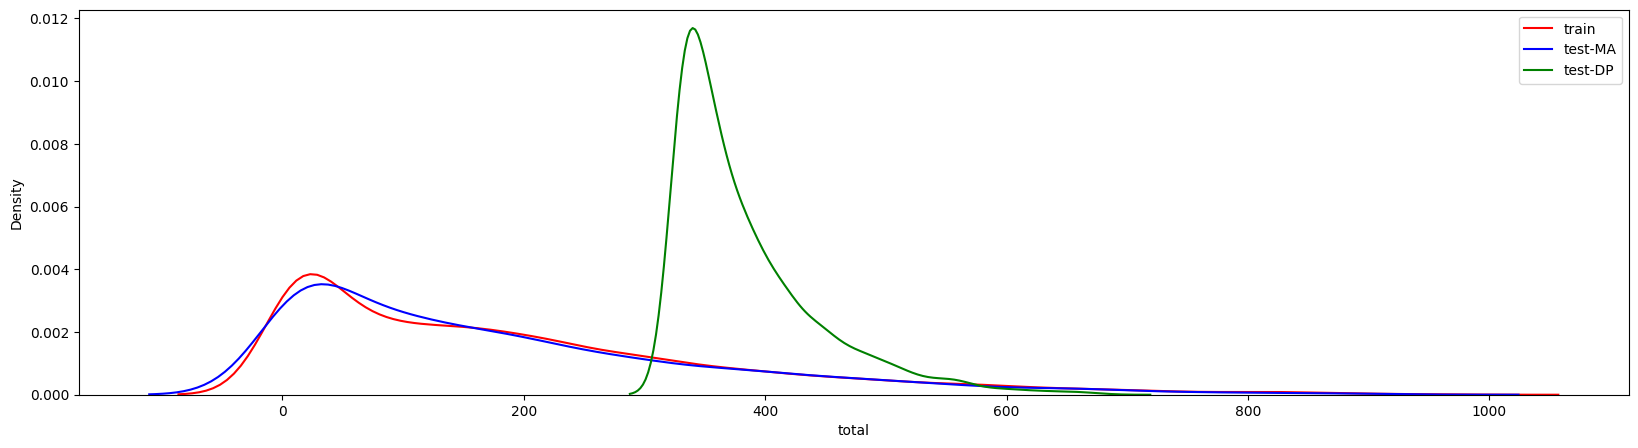

In [41]:
plt.figure(figsize=(20,5))
ax1 = sns.kdeplot(y_train, label = 'train',color="red")
ax2 = sns.kdeplot(machine_learning_prediction, label = 'test-MA',color="blue")
ax3 = sns.kdeplot(deep_learning_prediction1, label = 'test-DP',color="green")

plt.legend()
plt.show()

In [42]:
print(len(deep_learning_prediction))
print(len(machine_learning_prediction))
print(len(y_train))

2433
2433
9732


In [43]:
i = 100
print(deep_learning_prediction[i][0],machine_learning_prediction[i],y_train[i])

330.29367 8.0 50


In [44]:
# Check sizes
print(len(deep_learning_prediction))
print(len(machine_learning_prediction))

# Adjust loop range to the smallest array length
min_length = min(len(deep_learning_prediction), len(machine_learning_prediction))
final_pred = []
for i in range(min_length):
    final_pred.append((deep_learning_prediction[i][0] + machine_learning_prediction[i]) / 2)

# Print the final predictions
print(final_pred)

2433
2433
[191.25332641601562, 165.8724822998047, 202.7960662841797, 277.30384826660156, 274.0184631347656, 233.99876403808594, 180.65892028808594, 234.99041748046875, 301.14393615722656, 215.712158203125, 307.5569763183594, 211.6683349609375, 186.0738067626953, 328.68603515625, 175.23658752441406, 172.95298767089844, 174.43951416015625, 232.1900634765625, 189.8019256591797, 237.40415954589844, 252.08827209472656, 307.27525329589844, 487.69575439453126, 276.4413604736328, 366.77867126464844, 195.99635314941406, 261.4269561767578, 224.0523223876953, 203.5733184814453, 176.80125427246094, 202.40626525878906, 332.09434509277344, 280.84300231933594, 203.2827606201172, 501.1502020263672, 166.58583068847656, 332.6448211669922, 227.12994384765625, 166.31346130371094, 186.0838165283203, 287.81541442871094, 192.94036865234375, 256.6506042480469, 418.7923252360026, 228.43678283691406, 327.40113830566406, 201.1457977294922, 315.10169982910156, 171.53880310058594, 194.86268615722656, 242.674362182

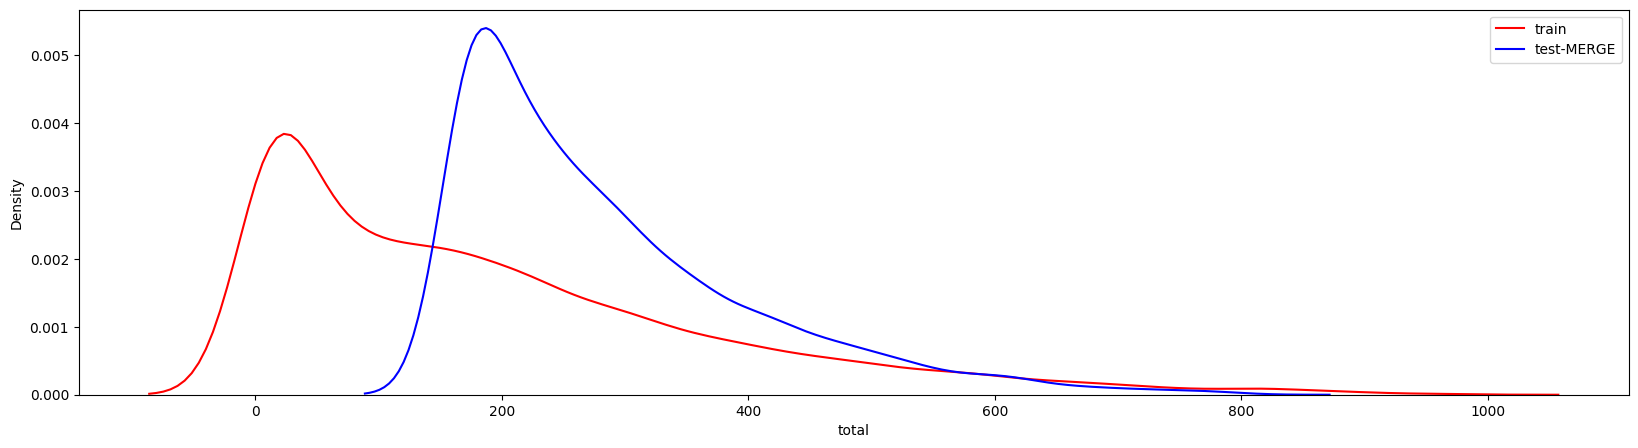

In [45]:
plt.figure(figsize=(20,5))
ax1 = sns.kdeplot(y_train, label = 'train',color="red")
ax2 = sns.kdeplot(final_pred, label = 'test-MERGE',color="blue")

plt.legend()
plt.show()

In [ ]:
final_pred = [(dl_pred[0] + ml_pred) / 2 for dl_pred, ml_pred in zip(deep_learning_prediction, machine_learning_prediction)]

# Create a DataFrame for prediction
predictions_df = pd.DataFrame({
    'Deep_Learning_Prediction': [pred[0] for pred in deep_learning_prediction],
    'Machine_Learning_Prediction': machine_learning_prediction,
    'Final_Prediction': final_pred
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")

# Read the CSV file
file_prediction = 'C:\capstoneproject3\predictions.csv'
df = pd.read_csv(file_prediction)

print(df.head())

Predictions saved to predictions.csv
   Deep_Learning_Prediction  Machine_Learning_Prediction  Final_Prediction
0                 339.50665                         43.0        191.253326
1                 327.74496                          4.0        165.872482
2                 343.59213                         62.0        202.796066
3                 377.60770                        177.0        277.303848
4                 376.03693                        172.0        274.018463


<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
C:\Users\jorda\AppData\Local\Temp\ipykernel_12104\2199674358.py:19: SyntaxWarning: invalid escape sequence '\c'
  file_prediction = 'C:\capstoneproject3\predictions.csv'
